# Insurance outlier detection

## Table of Contens

- Data Peprocessing
    - Data wrangling and exploration
    - Removing corelated columns
- Models
  - Isolated Forest
  - Local Outlier Factor
- Models Comparison

### Importing neccessary moduls

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import missingno as msno 

### Data wrangling and exploration

In [7]:
df = pd.read_csv('insurance_claims.csv')
df_init = df.copy()
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,pred
0,328,48,521585,10/17/2014,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,-1
1,228,42,342868,6/27/2006,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,-1
2,134,29,687698,9/6/2000,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,1
3,256,41,227811,5/25/1990,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,-1
4,228,44,367455,6/6/2014,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,1


#### Missing values

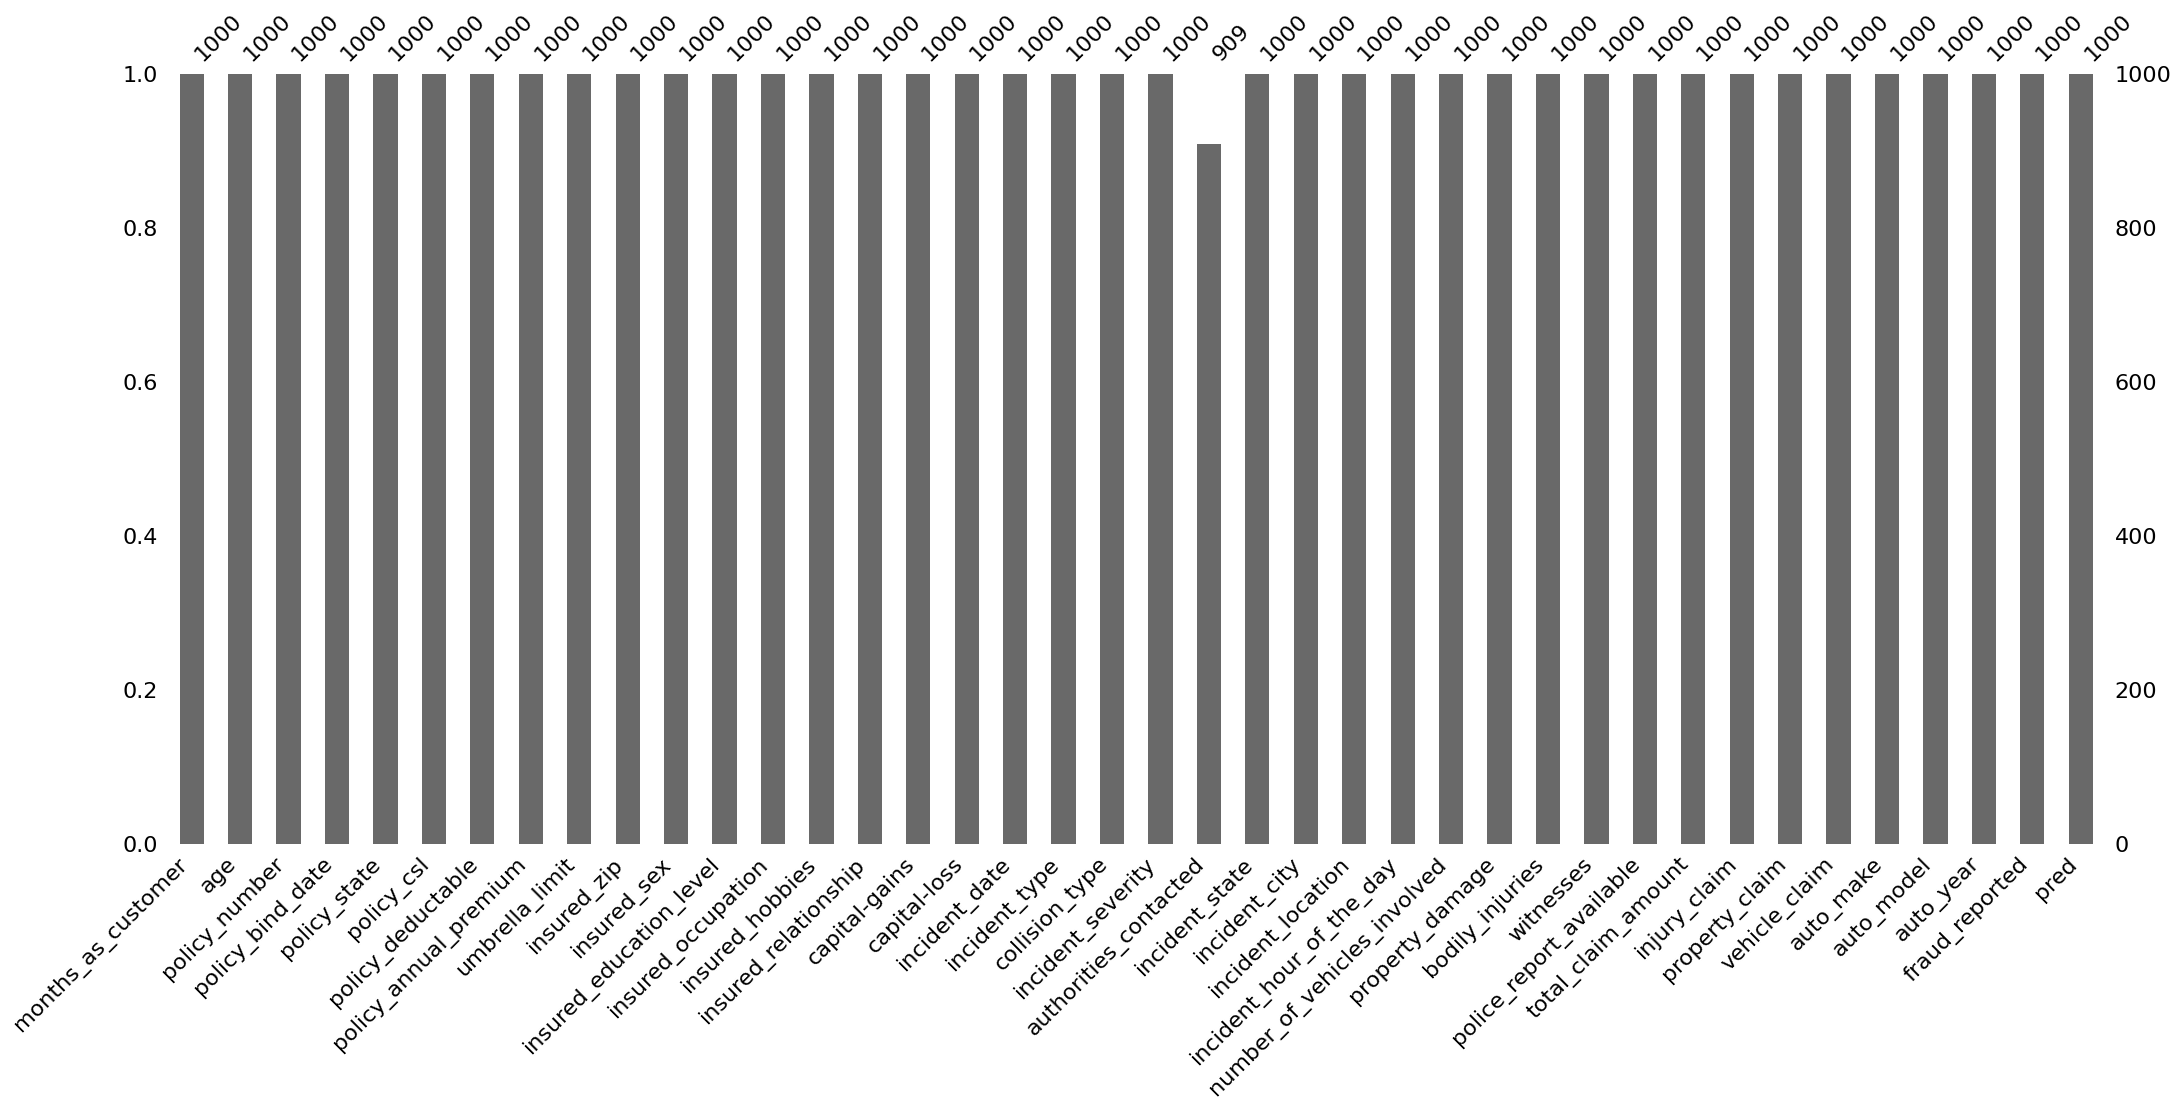

In [9]:
msno.bar(df)
plt.show()

In [10]:
df.isna().sum()

months_as_customer              0
age                             0
policy_number                   0
policy_bind_date                0
policy_state                    0
policy_csl                      0
policy_deductable               0
policy_annual_premium           0
umbrella_limit                  0
insured_zip                     0
insured_sex                     0
insured_education_level         0
insured_occupation              0
insured_hobbies                 0
insured_relationship            0
capital-gains                   0
capital-loss                    0
incident_date                   0
incident_type                   0
collision_type                  0
incident_severity               0
authorities_contacted          91
incident_state                  0
incident_city                   0
incident_location               0
incident_hour_of_the_day        0
number_of_vehicles_involved     0
property_damage                 0
bodily_injuries                 0
witnesses     

In [11]:
df.nunique()

months_as_customer              391
age                              46
policy_number                  1000
policy_bind_date                951
policy_state                      3
policy_csl                        3
policy_deductable                 3
policy_annual_premium           991
umbrella_limit                   11
insured_zip                     995
insured_sex                       2
insured_education_level           7
insured_occupation               14
insured_hobbies                  20
insured_relationship              6
capital-gains                   338
capital-loss                    354
incident_date                    60
incident_type                     4
collision_type                    4
incident_severity                 4
authorities_contacted             4
incident_state                    7
incident_city                     7
incident_location              1000
incident_hour_of_the_day         24
number_of_vehicles_involved       4
property_damage             

In [12]:
df_init['pred'].value_counts()

pred
 1    753
-1    247
Name: count, dtype: int64

In [13]:
# Dropping columns
to_drop = ['policy_number','policy_bind_date','policy_state','insured_zip','incident_location','incident_date',
           'insured_hobbies','auto_make','auto_model','auto_year', 'pred']

df.drop(to_drop, inplace=True, axis = 1)

#### Checking for multicollinearity

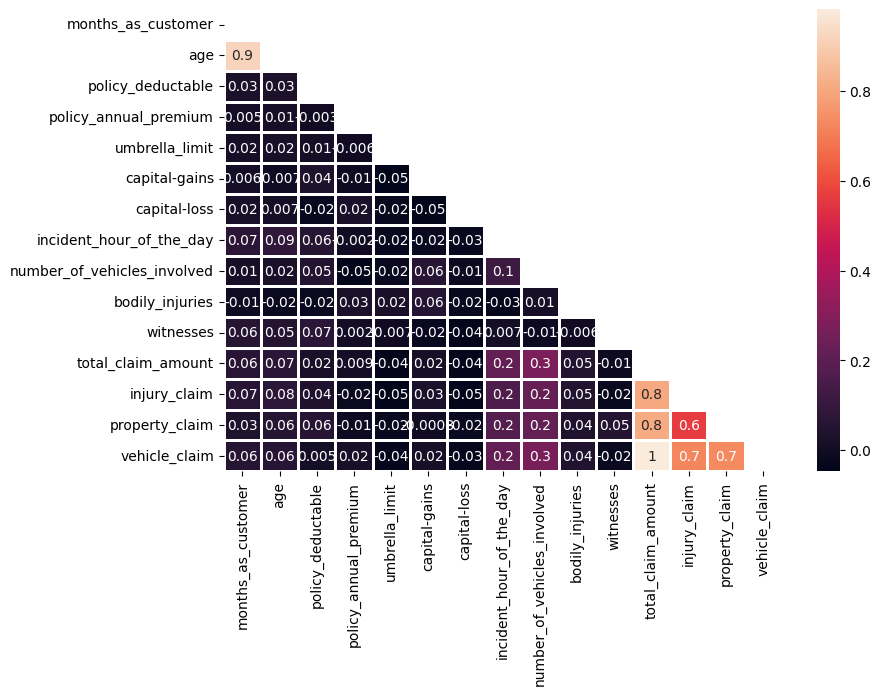

In [15]:
plt.figure(figsize = (9, 6))

corr = df.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(data = corr, mask = mask, annot = True, fmt = '.1g', linewidth = 1)
plt.show()

From the above plot, we can see that there is high correlation between age and months_as_customer.We will drop the `months_as_customer` column. Also there is high correlation between `total_clam_amount`, `injury_claim`, `property_claim`, `vehicle_claim` as `total claim` is the sum of all others. So we will drop the `total_claim` column.

In [17]:
df.drop(columns = ['months_as_customer', 'total_claim_amount'], inplace = True, axis = 1)

### Distributions

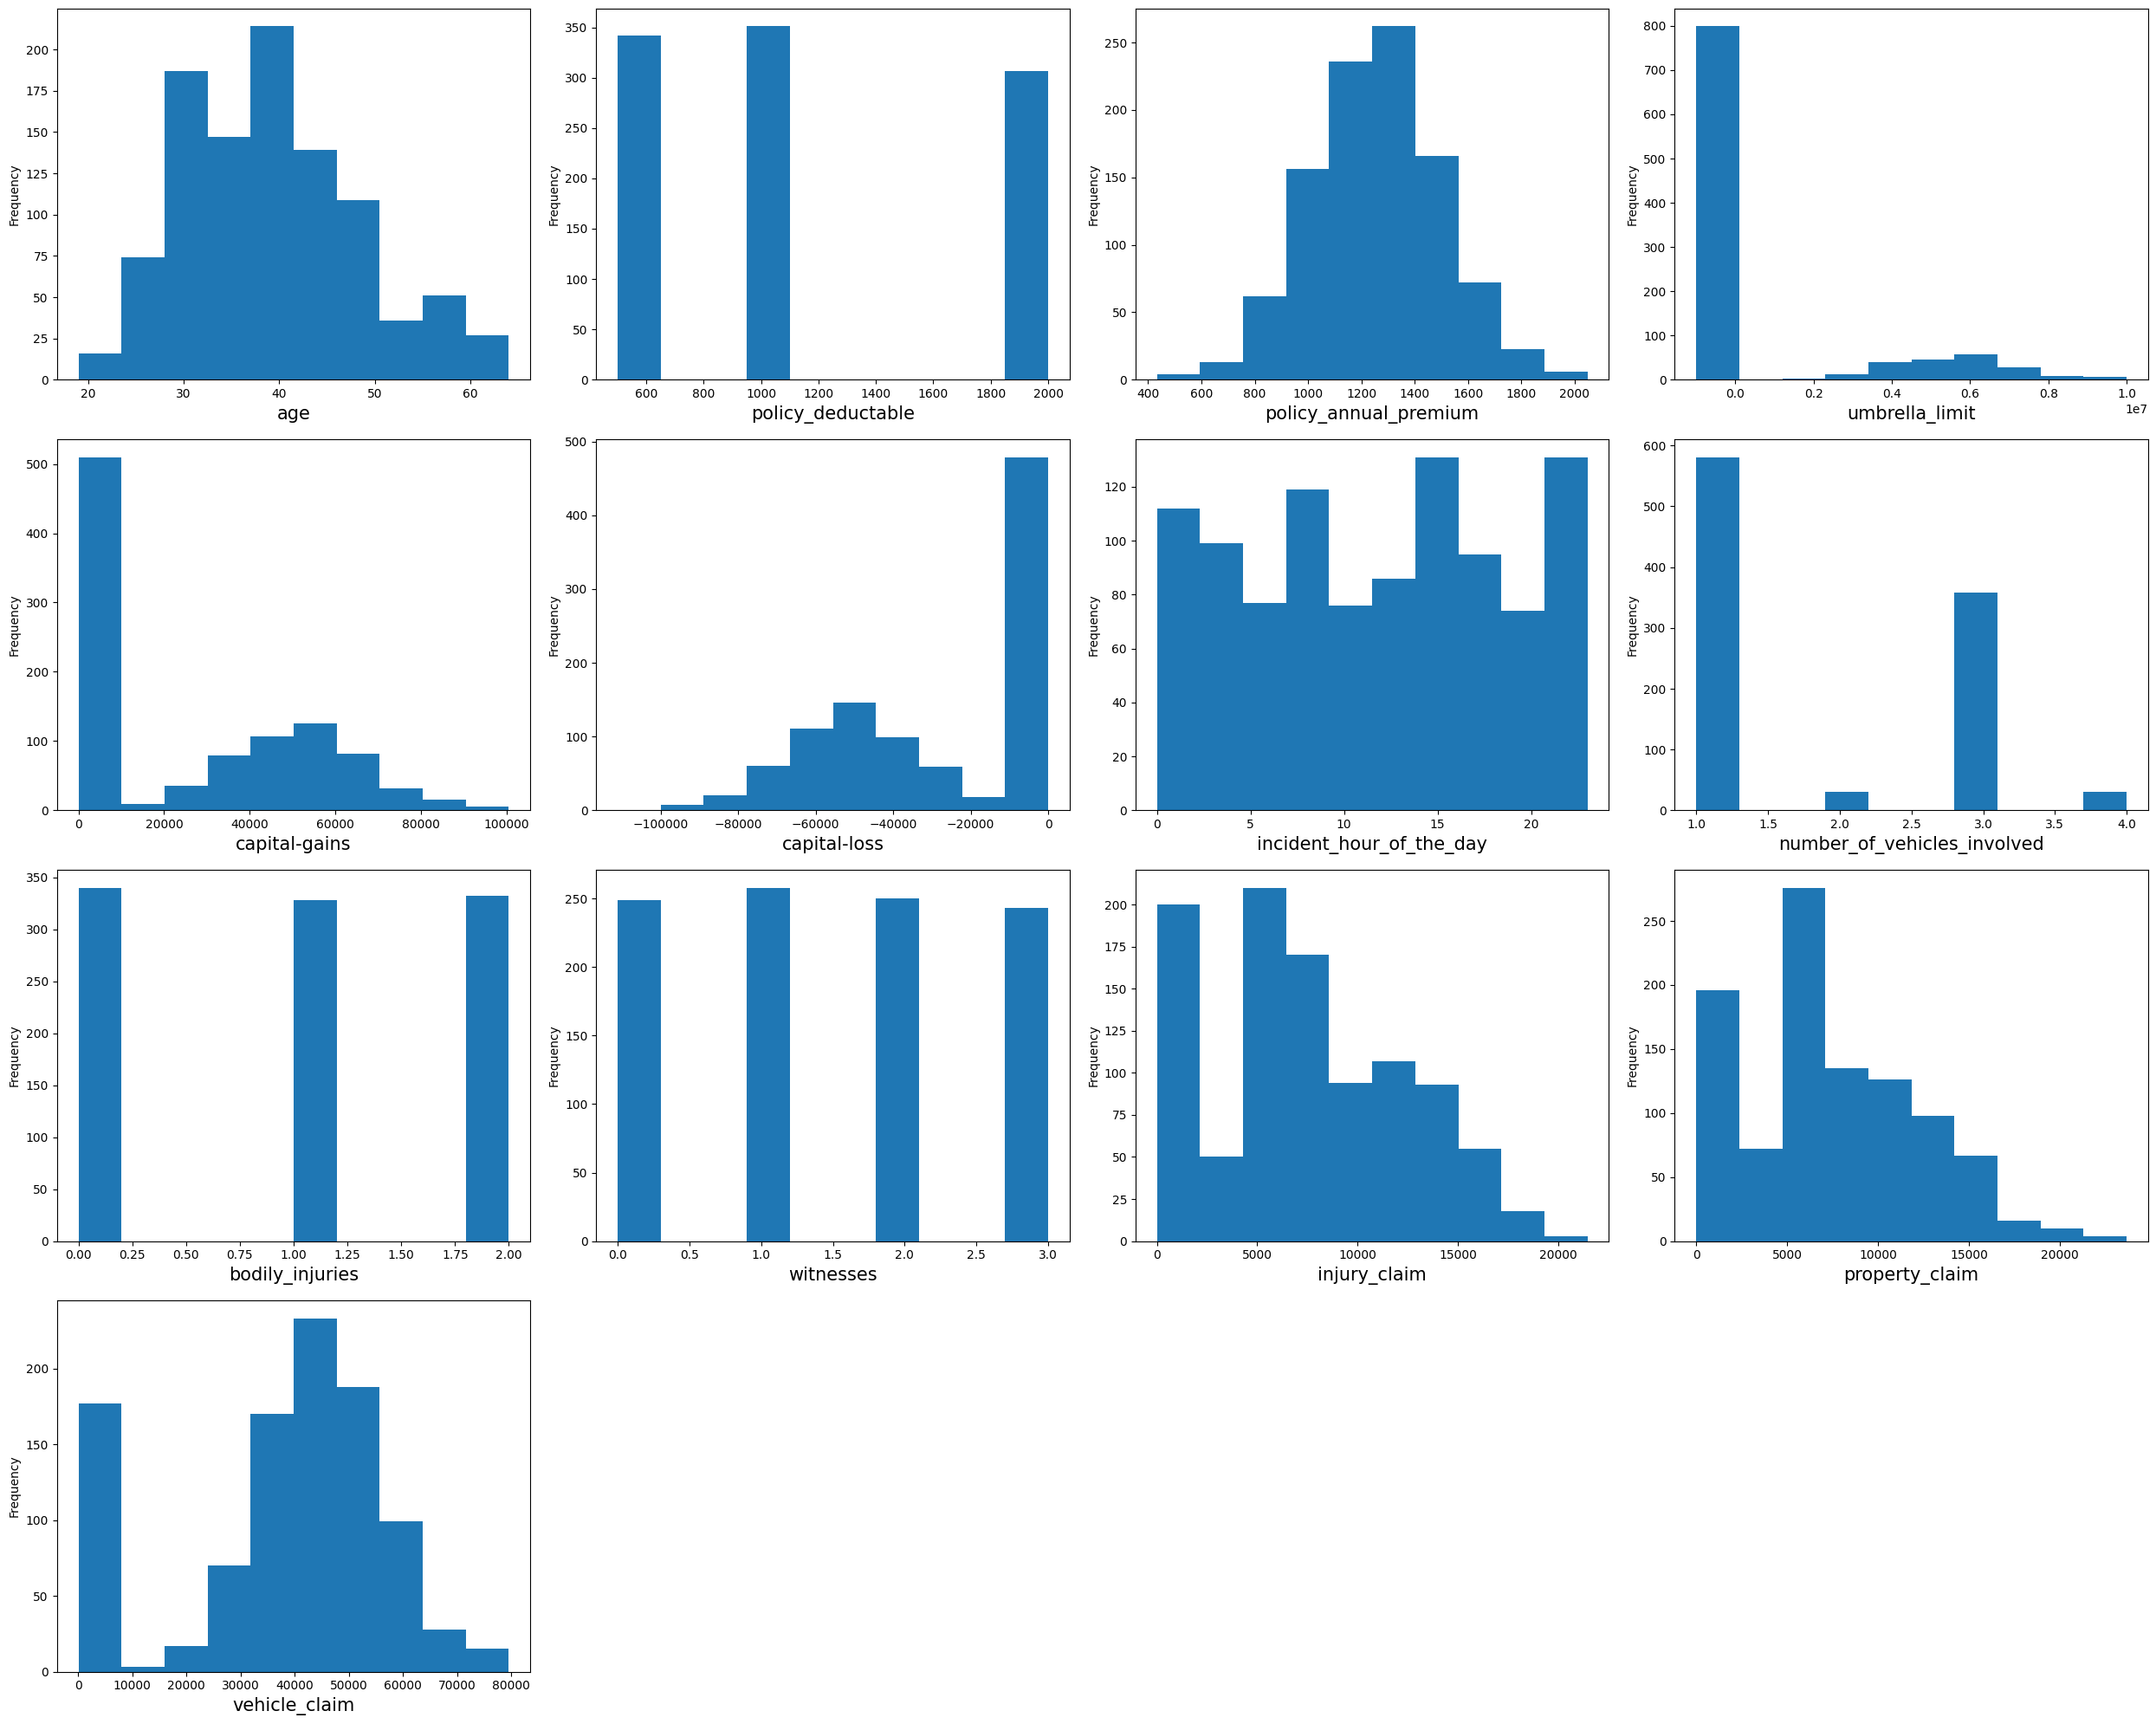

In [19]:
plt.figure(figsize = (25, 20))
plotnumber = 1

for col in df.select_dtypes(include=np.number).columns:
    if plotnumber <= 16:
        ax = plt.subplot(4, 4, plotnumber)
        df[col].plot(kind='hist')
        plt.xlabel(col, fontsize = 15)

    plotnumber += 1

plt.tight_layout()
plt.show()

### Drop based on distribution

In [21]:
to_drop_by_dist=['policy_deductable', 'number_of_vehicles_involved', 'bodily_injuries', 'incident_hour_of_the_day', 'witnesses']

In [22]:
df.drop(to_drop_by_dist, inplace = True, axis = 1)

## Models

In [24]:
df_if=df.select_dtypes(include=np.number)

In [25]:
df_if.head()

,age,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,injury_claim,property_claim,vehicle_claim
0,48,1406.91,0,53300,0,6510,13020,52080
1,42,1197.22,5000000,0,0,780,780,3510
2,29,1413.14,5000000,35100,0,7700,3850,23100
3,41,1415.74,6000000,48900,-62400,6340,6340,50720
4,44,1583.91,6000000,66000,-46000,1300,650,4550


## Isolation Forest

In [84]:
model=IsolationForest(n_estimators=300, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(df_if)

IsolationForest(contamination=0.1, n_estimators=300)

In [86]:
df_if['scores'] = model.decision_function(df_if)
df_if['anomaly'] = model.predict(df_if)
df_if.head(20)

,age,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,injury_claim,property_claim,vehicle_claim,scores,anomaly
0,48,1406.91,0,53300,0,6510,13020,52080,0.102122,1
1,42,1197.22,5000000,0,0,780,780,3510,0.041446,1
2,29,1413.14,5000000,35100,0,7700,3850,23100,0.036514,1
3,41,1415.74,6000000,48900,-62400,6340,6340,50720,0.054760,1
4,44,1583.91,6000000,66000,-46000,1300,650,4550,-0.021891,-1
5,39,1351.10,0,0,0,6410,6410,51280,0.137911,1
6,34,1333.35,0,0,-77000,21450,7150,50050,-0.005690,1
7,37,1137.03,0,0,0,9380,9380,32830,0.130247,1
8,33,1442.99,0,0,0,2770,2770,22160,0.095313,1
9,42,1315.68,0,0,-39300,4700,4700,32900,0.116995,1


In [88]:
anomaly = df_if.loc[df_if['anomaly']==-1]
anomaly_index= list(anomaly.index)
print(anomaly)

     age  policy_annual_premium  umbrella_limit  capital-gains  capital-loss  \
4     44                1583.91         6000000          66000        -46000   
11    61                1137.16               0              0        -51000   
41    34                1737.66               0              0        -24100   
48    34                1123.87         8000000              0             0   
50    59                1326.62         7000000              0             0   
66    31                1239.22         7000000          43400        -91200   
67    64                 835.02               0          59600             0   
88    36                1318.24         9000000              0        -78600   
91    23                1136.83         4000000              0        -62400   
95    25                1075.18         5000000          67700        -58400   
106   61                1125.37               0              0        -56400   
115   46                1110.37        1

### Analyse

**Confusion matrix**

In [92]:
a = confusion_matrix(df_if['anomaly'], df_init['pred'])

In [115]:
precision= (a[0,0]+a[1,1])/1000
print('Precison of IF method', precision)

Precison of IF method 0.727


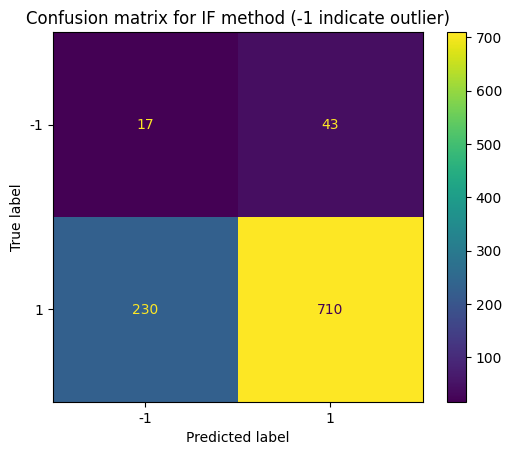

In [136]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = a, display_labels = [-1, 1])
cm_display.plot()
plt.title("Confusion matrix for IF method (-1 indicate outlier)")
plt.show()


## Local Outlier factor

In [120]:
from sklearn.neighbors import LocalOutlierFactor

In [122]:
clf = LocalOutlierFactor(n_neighbors=60, contamination=0.1)

In [124]:
y_pred = clf.fit_predict(df_if)

In [126]:
b = confusion_matrix(y_pred, df_init['pred'])

In [132]:
precision = (b[0,0] + b[1,1])/1000
print('Precision of LOF method', precision)

Precision of LOF method 0.703


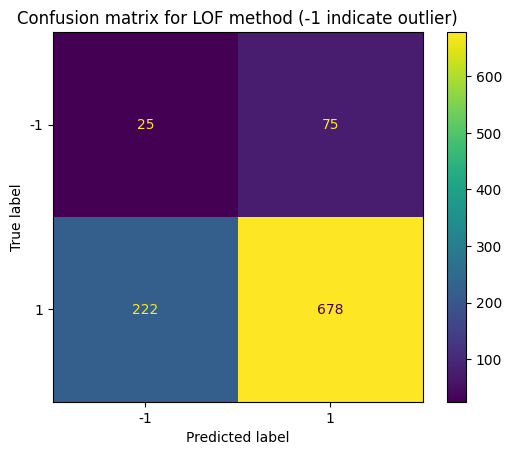

In [138]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = b, display_labels = [-1, 1])
cm_display.plot()
plt.title("Confusion matrix for LOF method (-1 indicate outlier)")
plt.show()